In [35]:
!pip install tensorflow-io==0.27.0 tensorflow==2.10.0
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow_io as tfio

In [36]:
cd /content/drive/MyDrive/mnist_audio

/content/drive/MyDrive/mnist_audio


In [37]:
def load_sound(filename):
    contents = tf.io.read_file(filename)

    wav, rate = tf.audio.decode_wav(contents, desired_channels = 1)

    wav = tf.squeeze(wav, axis = 1)
    rate = tf.cast(rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=rate,rate_out = 8000)
    return wav

def create_spectrogram(file, label):
    wav = load_sound(file)
    wav = wav[:8000]
    zero_padding = tf.zeros([8000] - tf.shape(wav),dtype = tf.float32)
    wav = tf.concat([zero_padding,wav],0)
    spectrogram = tf.signal.stft(wav,frame_length = 320, frame_step = 32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    return spectrogram, label

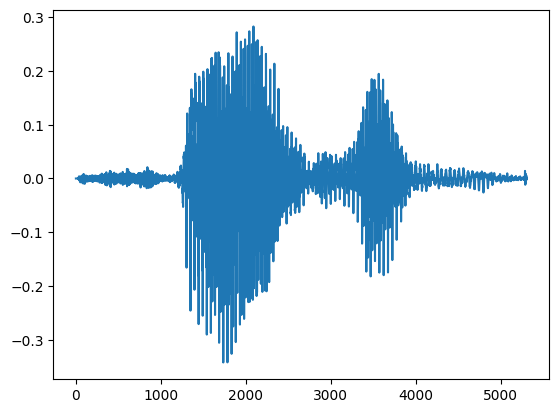

In [38]:
wav = load_sound('recordings/7_george_23.wav')
plt.plot(wav)
plt.show()

In [39]:
files = tf.data.Dataset.list_files('recordings/*.wav')
file_names = []
file_numbers = []
for file in files.as_numpy_iterator():
    name = file.decode('utf-8')
    file_names.append(name)
    file_numbers.append(name[name.index('/')+1])

dataset = tf.data.Dataset.from_tensor_slices((list(file_names), list(file_numbers)))

def to_int(file, label):
    return file,int(label)

dataset = dataset.map(to_int)
dataset = dataset.map(create_spectrogram)
dataset = dataset.cache()
dataset = dataset.shuffle(10000).batch(8).prefetch(8)

train = dataset.take(330)
test = dataset.skip(330).take(45)

In [40]:
'''
file, label = dataset.shuffle(10000).as_numpy_iterator().next()
spec, label = create_spectrogram(file, label)
plt.imshow(tf.transpose(spec)[0])
plt.show()
label
'''

'\nfile, label = dataset.shuffle(10000).as_numpy_iterator().next()\nspec, label = create_spectrogram(file, label)\nplt.imshow(tf.transpose(spec)[0])\nplt.show()\nlabel\n'

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(241, 257, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 239, 255, 16)      160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 119, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 117, 125, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 60, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 30, 64)      

In [42]:
hist = model.fit(train, epochs = 4, validation_data = test)

Epoch 1/4
330/330 [==============================] - 266s 527ms/step - loss: 0.9831 - accuracy: 0.7019 - val_loss: 0.3640 - val_accuracy: 0.8778
Epoch 2/4
330/330 [==============================] - 171s 518ms/step - loss: 0.3340 - accuracy: 0.9011 - val_loss: 0.1501 - val_accuracy: 0.9556
Epoch 3/4
330/330 [==============================] - 175s 531ms/step - loss: 0.1663 - accuracy: 0.9538 - val_loss: 0.0795 - val_accuracy: 0.9778
Epoch 4/4
330/330 [==============================] - 171s 516ms/step - loss: 0.1151 - accuracy: 0.9705 - val_loss: 0.0541 - val_accuracy: 0.9833


In [43]:
model.evaluate(test)

45/45 [==============================] - 6s 137ms/step - loss: 0.0837 - accuracy: 0.9750


[0.08368410170078278, 0.9750000238418579]

In [45]:
def prepare_prediction_audio(filepath):
    wav = load_sound(filepath)
    wav = wav[:8000]
    zero_padding = tf.zeros([8000] - tf.shape(wav),dtype = tf.float32)
    wav = tf.concat([zero_padding,wav],0)
    spectrogram = tf.signal.stft(wav,frame_length = 320, frame_step = 32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    spectrogram = tf.convert_to_tensor([spectrogram])
    return spectrogram

example = prepare_prediction_audio('test/test_aud.wav')
pred = model.predict(example)
print(pred,'\n')
print('Answer: ',np.argmax(pred))


1/1 [==============================] - 0s 101ms/step
[[8.1060678e-09 7.7588350e-04 3.7740384e-09 1.2621111e-09 1.1329623e-05
  9.9918622e-01 7.0692565e-08 8.7868229e-06 3.2509340e-07 1.7361050e-05]] 

Answer:  5
